In [106]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from itertools import combinations
from collections import defaultdict
import ast
import random

# Set random seed for reproducibility
random.seed(42)
print(torch.__version__)

2.3.1+cu121


In [86]:
data = pd.read_csv('/content/data_labeling - data.csv')

data.drop(columns= [x for x in data.columns if 'Unnamed' in x] + ['industry', 'sector', 'Comment'], inplace=True)

data.dropna(subset=['human_relationship'], inplace=True)

# List of columns to convert to string type
columns_to_convert = ['event', 'relationship', 'impact', 'human_event', 'human_relationship', 'human_impact']

# Convert specified columns to string type
data[columns_to_convert] = data[columns_to_convert].astype(str)

# Convert 'pubDate' column to datetime format
data['pubDate'] = pd.to_datetime(data['pubDate'], format='ISO8601')

# Convert the string representation of a list to an actual list
def parse_links(link_string):
    try:
        # Use ast.literal_eval to safely evaluate the string as a list
        return ast.literal_eval(link_string)
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing links: {e}")
        return []

# Apply the function to the 'links' column
data['links'] = data['links'].apply(parse_links)


display(data.head())
print(data.columns)


<ipython-input-86-4c2b0154a050>:14: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['pubDate'] = pd.to_datetime(data['pubDate'], format='ISO8601')


,articleId,article,pubDate,ticker,netReturn,links,keywords,topics,entities,reprint,event,relationship,impact,human_event,human_relationship,human_impact,Industry
0,e0662fc1befc4c48a0c55d8184ecc3b0,The Zacks Analyst Blog Highlights JPMorgan Cha...,2023-09-07 12:56:00+00:00,MMM,"[0.0027370694846706733, 0.01553080306900978, -...",[https://www.zacks.com/stock/news/2146020/the-...,"[{'name': 'next year', 'weight': 0.09366941}, ...","[{'name': 'Airbnb'}, {'name': 'Markets'}, {'na...","[{'data': 'JPMorgan Chase', 'type': 'ORG', 'me...",False,Revenue Discussions,Non-Causal,Not Relevant,Revenue Discussions,Non-Causal,Not Relevant,Industrials
1,e0662fc1befc4c48a0c55d8184ecc3b0,The Zacks Analyst Blog Highlights JPMorgan Cha...,2023-09-07 12:56:00+00:00,NOW,"[0.0012514182587504141, 0.009782183821121837, ...",[https://www.zacks.com/stock/news/2146020/the-...,"[{'name': 'next year', 'weight': 0.09366941}, ...","[{'name': 'Airbnb'}, {'name': 'Markets'}, {'na...","[{'data': 'JPMorgan Chase', 'type': 'ORG', 'me...",False,Revenue Discussions,Causal,Positive,Revenue Discussions,Causal,Neutral,Industrials
2,e0662fc1befc4c48a0c55d8184ecc3b0,The Zacks Analyst Blog Highlights JPMorgan Cha...,2023-09-07 12:56:00+00:00,AXP,"[0.004145970270181598, 0.0025408472182262276, ...",[https://www.zacks.com/stock/news/2146020/the-...,"[{'name': 'next year', 'weight': 0.09366941}, ...","[{'name': 'Airbnb'}, {'name': 'Markets'}, {'na...","[{'data': 'JPMorgan Chase', 'type': 'ORG', 'me...",False,Revenue Discussions,Non-Causal,Not Relevant,Revenue Discussions,Causal,Neutral,Industrials
3,e0662fc1befc4c48a0c55d8184ecc3b0,The Zacks Analyst Blog Highlights JPMorgan Cha...,2023-09-07 12:56:00+00:00,JPM,"[0.0007654764358859811, 0.004380096304694714, ...",[https://www.zacks.com/stock/news/2146020/the-...,"[{'name': 'next year', 'weight': 0.09366941}, ...","[{'name': 'Airbnb'}, {'name': 'Markets'}, {'na...","[{'data': 'JPMorgan Chase', 'type': 'ORG', 'me...",False,Revenue Discussions,Non-Causal,Not Relevant,Revenue Discussions,Causal,Positive,Industrials
4,e0662fc1befc4c48a0c55d8184ecc3b0,The Zacks Analyst Blog Highlights JPMorgan Cha...,2023-09-07 12:56:00+00:00,MMM,"[0.0027370694846706733, 0.01553080306900978, -...",[https://www.zacks.com/stock/news/2146020/the-...,"[{'name': 'next year', 'weight': 0.09366941}, ...","[{'name': 'Airbnb'}, {'name': 'Markets'}, {'na...","[{'data': 'JPMorgan Chase', 'type': 'ORG', 'me...",False,Margin/Profitability Discussions,Causal,Neutral,Margin/Profitability Discussions,Non-Causal,Not Relevant,Industrials


Index(['articleId', 'article', 'pubDate', 'ticker', 'netReturn', 'links',
       'keywords', 'topics', 'entities', 'reprint', 'event', 'relationship',
       'impact', 'human_event', 'human_relationship', 'human_impact',
       'Industry'],
      dtype='object')


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 387 entries, 0 to 520
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   articleId           387 non-null    object
 1   article             387 non-null    object
 2   pubDate             387 non-null    object
 3   ticker              387 non-null    object
 4   netReturn           387 non-null    object
 5   links               387 non-null    object
 6   keywords            387 non-null    object
 7   topics              387 non-null    object
 8   entities            386 non-null    object
 9   reprint             387 non-null    object
 10  event               387 non-null    object
 11  relationship        387 non-null    object
 12  impact              387 non-null    object
 13  human_event         387 non-null    object
 14  human_relationship  387 non-null    object
 15  human_impact        387 non-null    object
 16  Industry            387 non-nul

In [88]:
G = nx.DiGraph()
print(G.is_directed())

# Iterate over the DataFrame rows to add nodes and edges
for idx, row in data.iterrows():
    # Add the article node
    article_id = row['articleId']
    G.add_node(article_id, type='article', **row.to_dict())

    if article_id == '7ee008c9dae8434ca44a2a192ecb3689':
      print(row)

    # Add the ticker node if it's not already in the graph
    ticker = row['ticker']
    pub_date = pd.to_datetime(row['pubDate'])  # Convert to datetime

    if ticker not in G:
        G.add_node(ticker, type='ticker', pubDate=[pub_date])
    else:
        G.nodes[ticker]['pubDate'].append(pub_date)

    # Add an edge if the 'human_relationship' indicates a causal relationship
    if row['human_relationship'].lower() == 'causal':
        G.add_edge(article_id, ticker)

# Create a dictionary to map links to the articles that mention them
link_to_articles = defaultdict(set)

# Map links to the articles that mention them
for idx, row in data.iterrows():
    article_id = row['articleId']
    for link in list(row['links']):
      link_to_articles[link].add(article_id)


# Create edges between articles that share the same link
article_to_article_link_count = 0

for articles in link_to_articles.values():
    articles = list(articles)
    n = len(articles)
    for i in range(n):
        for j in range(i + 1, n):
            article1 = articles[i]
            article2 = articles[j]
            # Check if the edge already exists to avoid duplicates
            if not G.has_edge(article1, article2):
                G.add_edge(article1, article2)
                article_to_article_link_count += 1
            if not G.has_edge(article2, article1):
                G.add_edge(article2, article1)

print(f'Number of edges between articles that share the same link: {article_to_article_link_count}')

True
articleId                              7ee008c9dae8434ca44a2a192ecb3689
article               3M (MMM) Stock Moves -0.09%: What You Should Know
pubDate                                       2023-09-05 21:45:20+00:00
ticker                                                              MMM
netReturn             [-0.004492221613188074, -0.003948419989796004,...
links                 [https://www.zacks.com/registration/pfp?ALERT=...
keywords              [{'name': 'Strong Sell', 'weight': 0.07397522}...
topics                                                               []
entities              [{'data': '3', 'type': 'ORG', 'mentions': 6}, ...
reprint                                                           False
event                                               Revenue Discussions
relationship                                                 Non-Causal
impact                                                     Not Relevant
human_event                                         Revenue

In [89]:
for link in link_to_articles.keys():
  if(len(link_to_articles[link]) > 1):
    print(link, link_to_articles[link])

https://www.zacks.com/?t=MMM {'7ee008c9dae8434ca44a2a192ecb3689', '0adc0ab3393b495cb5f62687c433c0e5'}
https://www.thomsonreuters.com/en/about-us/trust-principles.html {'775775b496704290a52795f3593d3ba4', '798c695c28b84f9c859fb9a74de1dbeb', '270e5cd5049c4e169324bc5bea84de51', 'c4cf4816b7ac4b20977bf1fec9b06fb1', 'b9a654bcc2f7414a8496bba14b1a05f9', '7e7bf7c6ddb04f9abf2cec4946ac24ac', '395b84d8ced046aabe625eb19e4eda9c', 'efac8cb08f674fa6a0499601e53fe980', 'c8bb497013db4564b6b3364cf4ad3748', '3f9b6e3e103241b9996a931ebfb03459'}
https://www.reutersagency.com/en/licensereuterscontent/?utm_medium=rcom-article-media&utm_campaign=rcom-rcp-lead {'775775b496704290a52795f3593d3ba4', '798c695c28b84f9c859fb9a74de1dbeb', '270e5cd5049c4e169324bc5bea84de51', 'c4cf4816b7ac4b20977bf1fec9b06fb1', 'b9a654bcc2f7414a8496bba14b1a05f9', '7e7bf7c6ddb04f9abf2cec4946ac24ac', '395b84d8ced046aabe625eb19e4eda9c', 'efac8cb08f674fa6a0499601e53fe980', 'c8bb497013db4564b6b3364cf4ad3748', '3f9b6e3e103241b9996a931ebfb03459'

The links mentioned in more than 1 articles often don't seem relevant.

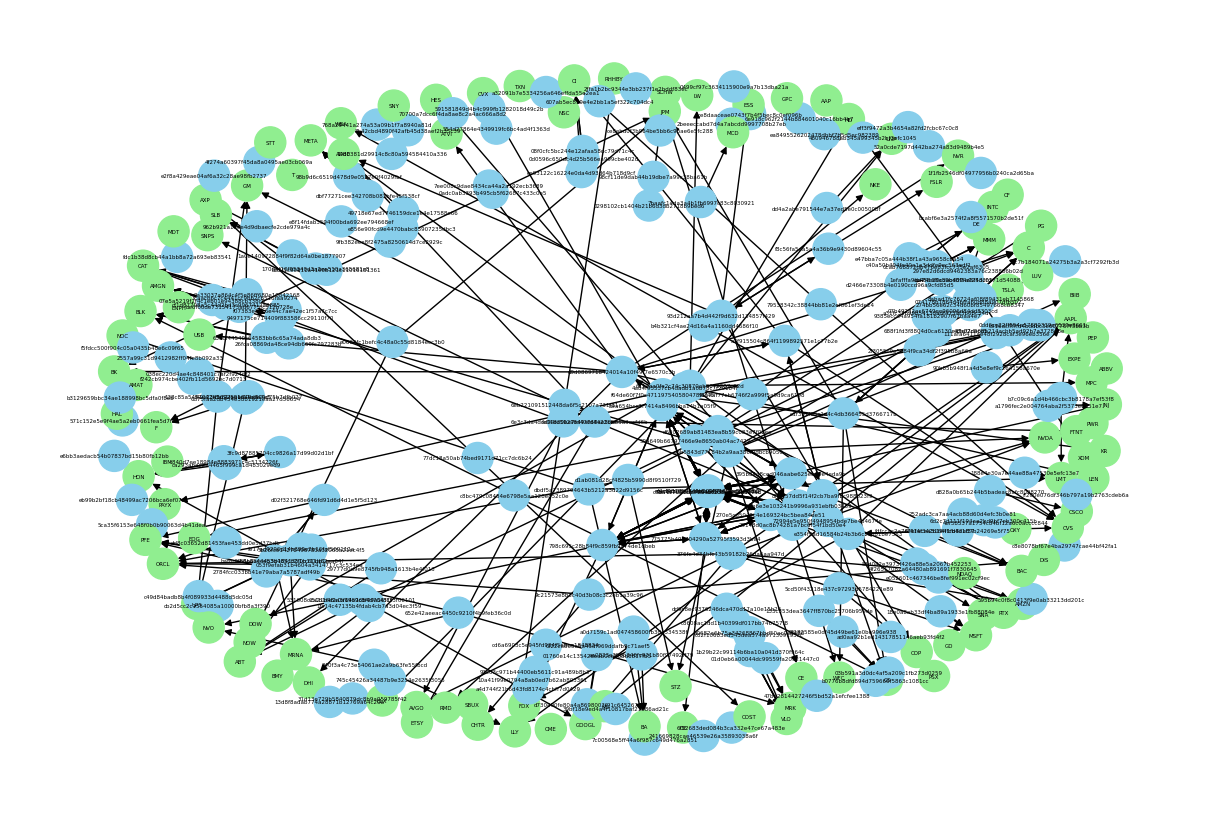

In [90]:
def plot_graph(G):
  color_map = []
  for node in G.nodes(data=True):
    if node[1]['type'] == 'article':
        color_map.append('skyblue')  # Color for 'article' nodes
    else:
        color_map.append('lightgreen')  # Color for 'ticker' nodes

  # Example using the spring layout
  pos = nx.spring_layout(G, seed=42)  # You can adjust the seed for different layouts
  plt.figure(figsize=(12, 8))
  nx.draw(G, pos, with_labels=True, node_size=500, node_color=color_map, font_size=4, font_color='black')
  plt.show()

plot_graph(G)

In [91]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')

degrees = dict(G.degree())
# print('Node degrees:', degrees)

avg_degree = sum(degrees.values()) / num_nodes
print('Average degree:', avg_degree)

density = nx.density(G)
print('Graph density:', density)

# Find isolated nodes
isolated_nodes = list(nx.isolates(G))
print(f'Isolated nodes: count={len(isolated_nodes)}, {isolated_nodes}')

is_strongly_connected = nx.is_strongly_connected(G)
print(f'Is the graph strongly connected? {is_strongly_connected}')

is_weakly_connected = nx.is_weakly_connected(G)
print(f'Is the graph weakly connected? {is_weakly_connected}')

# Check for self-loops by iterating through nodes
self_loop = False
for node in G.nodes():
    if G.has_edge(node, node):
        print(f"Node {node} has a self-loop.")
        self_loop = True

if not self_loop:
    print("The graph does NOT have self-loops.")

Number of nodes: 295
Number of edges: 365
Average degree: 2.4745762711864407
Graph density: 0.004208463046235443
Isolated nodes: count=53, ['IBM', '3c7b184071a24275b3a2a3cf7292fb3d', 'PWR', 'fdc1b38d8cb44a1bb8a72a693eb83541', '31d13e729b5840879dc8b9a059785f42', 'e6bb3aedacb54b07837bd15b80fb12bb', '5ca35f6153e648f0b0b90063d4b41dea', 'c8e8078bf67e4ba29747cae44bf42fa1', 'NSC', 'ce8daaceae0743f7b4f5bec8c0ef096b', 'T', '52a0cde7197d442ba274a83d9489b4e5', '4f274a60397f45da8a0495ae03cb069a', '6f52683ded084b3ca332e47ce67a483e', 'eff3f9472a3b4654a82fd2fcbc67c0c8', 'TXN', 'AMAT', 'e8f14fdab3594f00bda692ee794668ef', 'ENPH', '0499cf97c3634115900e9a7b13dba21a', 'STT', 'cb2d5cc2c1554085a10000bfb8a3f390', 'SBUX', '8b42cbd4890f42afb45d38aef2b35c39', '241669828cae46539e26a35893038a6f', 'eb99b2bf18cb48499ac7206bca6ef072', '6e918c962f2144b884601040c16bb4b7', '480946788ab345a99345b2bf3efc1045', 'ea8495526202478dbbf7b5d5ec982389', 'a32091b7e5334256a646effda55e2ea1', 'f5fdcc500f904c05a0435b48e6c09f65', '768

In [92]:
# 1. Closeness Centrality
closeness = nx.closeness_centrality(G)

# 2. Betweenness Centrality
betweenness = nx.betweenness_centrality(G)

# 3. Triangle Count (Note: Not directly applicable to DiGraph, so we'll convert to undirected)
triangle_count = nx.triangles(G.to_undirected())

# 4. Clustering Coefficient (Note: For DiGraph, it computes local clustering on the underlying undirected graph)
clustering_coefficient = nx.clustering(G.to_undirected())

# 5. PageRank
page_rank = nx.pagerank(G)

# 6. Community Detection (e.g., using the Girvan-Newman method or a similar algorithm)
from networkx.algorithms import community

# Using the Girvan-Newman method for community detection
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
community_dict = {node: idx for idx, community in enumerate(top_level_communities) for node in community}

# 7. Node Type (article or ticker)
node_type = nx.get_node_attributes(G, 'type')

# Combine all metrics into a DataFrame
metrics_df = pd.DataFrame({
    'node_type': node_type,
    'closeness': closeness,
    'betweenness': betweenness,
    'triangle_count': triangle_count,
    'clustering_coefficient': clustering_coefficient,
    'page_rank': page_rank,
    'community': community_dict,
})

# Display the DataFrame
display(metrics_df)

,node_type,closeness,betweenness,triangle_count,clustering_coefficient,page_rank,community
e0662fc1befc4c48a0c55d8184ecc3b0,article,0.000000,0.000000,0,0.000000,0.001970,0
MMM,ticker,0.006803,0.000000,0,0.000000,0.005319,1
NOW,ticker,0.003401,0.000000,0,0.000000,0.002528,0
AXP,ticker,0.010204,0.000000,0,0.000000,0.005040,0
JPM,ticker,0.014172,0.000000,0,0.000000,0.004717,0
...,...,...,...,...,...,...,...
CI,ticker,0.018519,0.000000,0,0.000000,0.008428,0
08f0cfc5bc244e12afaa58dc79d71c4c,article,0.000000,0.000000,0,0.000000,0.001970,0
a7f915504c864f1199892571e1c77b2e,article,0.006803,0.000046,1,0.166667,0.002812,0
79538342c38844bb81e2ef861ef3de24,article,0.000000,0.000000,0,0.000000,0.001970,0


In [93]:
metrics_df.describe()

,closeness,betweenness,triangle_count,clustering_coefficient,page_rank,community
count,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000
mean,0.004758,0.000005,1.393220,0.097329,0.003390,16.145763
std,0.007925,0.000025,6.516955,0.269390,0.002423,20.947678
min,0.000000,0.000000,0.000000,0.000000,0.001970,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.001970,3.000000
50%,0.000000,0.000000,0.000000,0.000000,0.001970,3.000000
75%,0.006122,0.000000,0.000000,0.000000,0.003801,28.500000
max,0.047832,0.000209,36.000000,1.000000,0.015464,73.000000


## Filter graph by date

In [94]:
def get_subgraph_for_date(G, target_date):
    # Convert the target date to a datetime object if it's a string
    target_date = pd.to_datetime(target_date)

    # Create a subgraph with nodes that match the target date
    nodes_to_keep = set()

    for node_id, node_data in G.nodes(data=True):
        if len(node_data) == 0:
            print('Empty node data:', node_id)
            continue  # Skip empty nodes

        # For article nodes, check if the pubDate matches the target date
        if node_data['type'] == 'article' and pd.to_datetime(node_data['pubDate']).date() == target_date.date():
            nodes_to_keep.add(node_id)

        # For ticker nodes, check if any pubDate in the list matches the target date
        if node_data['type'] == 'ticker' and any(pd.to_datetime(date).date() == target_date.date() for date in node_data['pubDate']):
            nodes_to_keep.add(node_id)

    # Create a subgraph with the nodes that match the target date
    subgraph = G.subgraph(nodes_to_keep).copy()

    return subgraph

# Example usage
target_date = '2023-09-07'  # Replace with the desired date
subgraph = get_subgraph_for_date(G, target_date)

# Print the nodes and edges in the subgraph
print(f"{subgraph.number_of_nodes()} Nodes in the subgraph:")
print(subgraph.nodes(data=True))
print(f"\n{subgraph.number_of_edges()} Edges in the subgraph:")
print(subgraph.edges(data=True))

82 Nodes in the subgraph:
[('29777d0d9e8745fb948a1613b4e4f013', {'type': 'article', 'articleId': '29777d0d9e8745fb948a1613b4e4f013', 'article': 'Abbott Joins Billion Dollar Roundtable', 'pubDate': Timestamp('2023-09-07 17:15:00+0000', tz='UTC'), 'ticker': 'ABT', 'netReturn': '[0.0005960057533600516, 0.01707529563734478, -0.0004879539349708084, 0.002832013784676235, -0.00038949605411753296]', 'links': ['https://pr.report/OHLrVBSw', 'https://pr.report/FDBCQdZk', 'https://pr.report/y8rp6-Zw', 'https://www.accesswire.com/781824/abbott-joins-billion-dollar-roundtable', 'https://pr.report/HgtK63hk', 'https://pr.report/2OdkDGwA'], 'keywords': "[{'name': 'diverse businesses', 'weight': 0.12459816}, {'name': 'diverse small businesses', 'weight': 0.11962249}, {'name': 'business continuity', 'weight': 0.1046412}, {'name': 'businesses', 'weight': 0.10395203}, {'name': 'Diverse Businesses', 'weight': 0.10339367}, {'name': 'diverse companies', 'weight': 0.09826201}, {'name': 'diverse suppliers', 'we

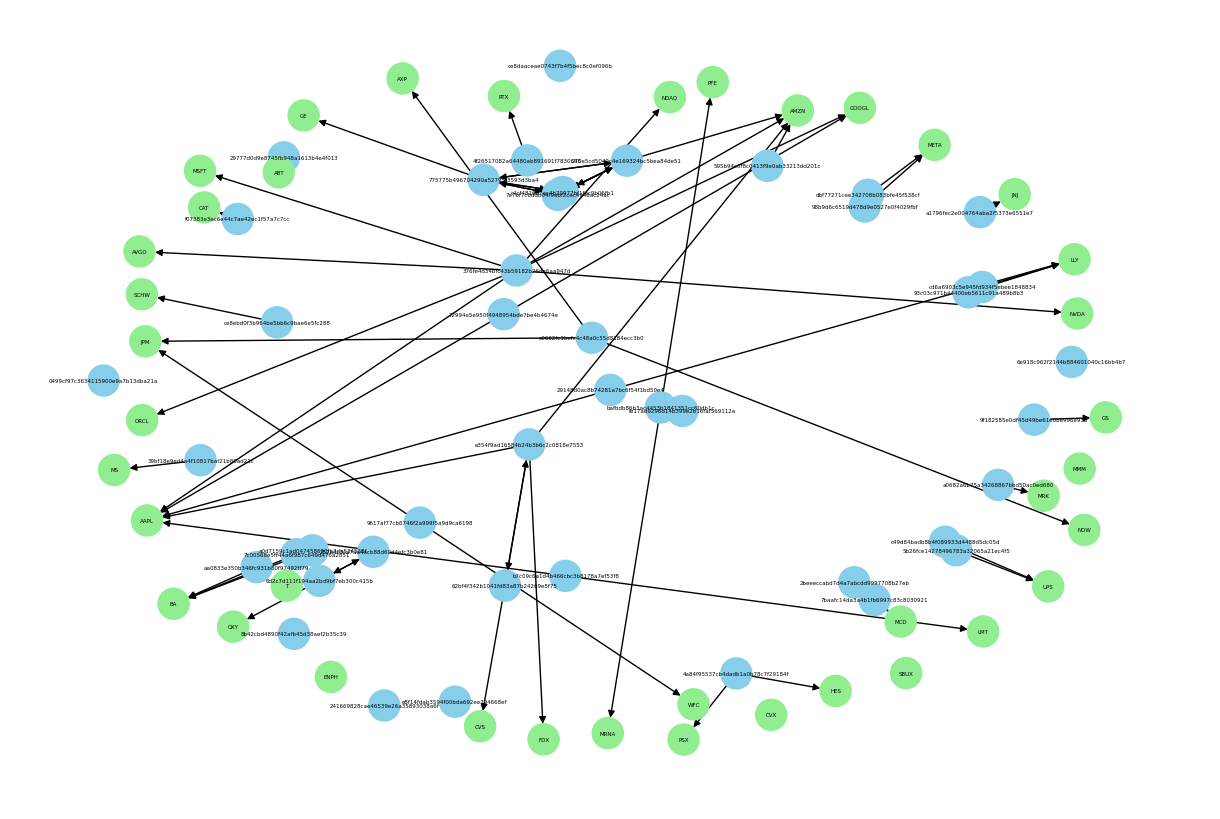

In [95]:
plot_graph(subgraph)

## Create node embeddings

In [96]:
import torch
import torch.nn as nn

# Create an embedding layer for 10 categories (e.g., words), with embedding size 3
embedding = nn.Embedding(10, 3)

# Input with indices of categories (e.g., word indices)
input_indices = torch.tensor([1, 2, 3])

# Get the corresponding embeddings
output = embedding(input_indices)
print(output)


tensor([[ 0.7006, -0.0590, -1.7446],
        [-1.5180,  1.2270,  0.2751],
        [-0.6630,  0.9058,  0.1182]], grad_fn=<EmbeddingBackward0>)


In [108]:
# Create a mapping from strings to unique integers
node_to_id = {}
current_id = 0

# Iterate over all edges to build the mapping
for edge in list(G.edges):
    for node in edge:
        if node not in node_to_id:
            node_to_id[node] = current_id
            current_id += 1

In [114]:
def create_samples(G, node_to_id, num_neg_samples):
    # Convert edges from graph G to positive samples using node_to_id mapping
    positive_edges = [(node_to_id[u], node_to_id[v]) for u, v in G.edges()]

    # Convert positive_edges to tensor
    positive_samples = torch.LongTensor(positive_edges).t()  # Shape [2, num_edges]
    print(f'positive_samples {positive_samples.shape}')

    # Create negative samples
    all_nodes = list(node_to_id.values())  # All node IDs (integers)
    num_edges = len(positive_edges)
    negative_edges = set()

    while len(negative_edges) < min(num_edges, num_neg_samples):
        # Randomly select two nodes
        u, v = random.sample(all_nodes, 2)
        # Ensure there's no edge between them in the original graph
        if u != v and not G.has_edge(list(node_to_id.keys())[u], list(node_to_id.keys())[v]):
            negative_edges.add((u, v))

    # Convert negative_edges to tensor
    negative_samples = torch.LongTensor(list(negative_edges)).t()  # Shape [2, num_edges]
    print(f'negative_samples {negative_samples.shape}')

    return positive_samples, negative_samples

# Example usage:
# Assume you have already built your graph G and created node_to_id mapping from the previous step.
positive_samples, negative_samples = create_samples(G, node_to_id, 0.8 * G.number_of_edges())

print("Positive Samples Tensor:\n", positive_samples)
print("Negative Samples Tensor:\n", negative_samples)

positive_samples torch.Size([2, 365])
negative_samples torch.Size([2, 292])
Positive Samples Tensor:
 tensor([[  0,   0,   0,   4,   5,   6,   8,   9,   9,   9,   9,   9,   9,   9,
           9,   9,   9,  20,  21,  17,  17,  17,  17,  17,  17,  17,  17,  17,
          22,  24,  25,  15,  15,  15,  15,  15,  15,  15,  15,  15,  26,  28,
          28,  30,  30,  29,  29,  32,  32,  35,  34,  34,  36,  36,  36,  39,
          39,  39,  39,  41,  43,  44,  44,  44,  47,  48,  50,  50,  52,  53,
          53,  53,  55,  57,  58,  59,  59,  59,  59,  59,  59,  59,  66,  67,
          67,  67,  67,  71,  71,  71,  71,  71,  71,  71,  71,  12,  12,  12,
          12,  12,  12,  12,  12,  12,  12,  76,  77,  77,  77,  81,  80,  80,
          82,  83,  84,  85,  86,  87,  19,  19,  19,  19,  19,  19,  19,  19,
          19,  19,  19,  88,  90,  79,  91,  92,  93,  94,  96,  96,  97,  98,
          99,  99,  99,  99,  99, 105, 105, 105, 105, 108, 108, 108, 108, 108,
         112, 113, 113, 113, 

In [117]:
# Please do not change / reset the random seed
torch.manual_seed(1)

def create_node_emb(num_node, embedding_dim=10):
  emb = nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim,
                     _weight=torch.rand(num_node, embedding_dim))

  return emb

emb = create_node_emb(len(node_to_id))

In [118]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['type'] == 'article':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="skyblue", label="article")
  plt.scatter(club2_x, club2_y, color="lightgreen", label="ticker")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 600x600 with 0 Axes>